# Science Fair 2020

By Neel Redkar

This uses different ways to try to predict an earthquake. Using local California data of earthquakes from 1967 onwards  with magnitudes over 4.0.

- [NCEDC dataset are here](http://ncedc.org/ncedc/catalog-search.html)
- [NCEDC continuous data](http://service.ncedc.org/fdsnws/dataselect/1/)
- [darksky api](https://darksky.net)
- [NCEDC Station Query](http://service.ncedc.org/fdsnws/station/1/)


**Ideas for NN**
- ~~LSTM NN~~
- ~~RNN~~
- CNN

## Imports

In [1]:
%matplotlib notebook
import tensorflow as tf
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm
import requests
import numpy as np
import matplotlib.pyplot as plt
import obspy
import math
import time
import datetime
from scipy import fftpack
import csv
import urllib.request
from termcolor import colored
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
print("Imported Modules")

Imported Modules


## Parsing

Here, I parse the csv given that has earthquakes in California from 1967 over a 4.0 magnitude.

In [41]:
earthquakes = []
with open('earthquakes.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        earthquakes.append(row)

In [42]:
print(earthquakes[:1])
earthquakes = earthquakes[1:]

[['DateTime', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'MagType', 'NbStations', 'Gap', 'Distance', 'RMS', 'Source', 'EventID']]


In [43]:
formatted_quakes = []
for earthquake in tqdm(earthquakes):
    formatted_quakes.append([float(time.mktime(datetime.datetime.strptime(earthquake[0], "%Y/%m/%d %H:%M:%S.%f").timetuple())),earthquake[1], earthquake[2], float(earthquake[4])])
formatted_quakes = np.array(formatted_quakes)
np.save("formatted_quakes.npy", formatted_quakes) # Save the numpy array as formated_quakes.npy
print("Finished parsing and saved as formatted_quakes.npy")


Finished parsing and saved as formatted_quakes.npy


In [3]:
formatted_quakes = np.load("formatted_quakes.npy")
np.random.shuffle(formatted_quakes)
print(formatted_quakes[:10])

[[b'1330175835.0' b'40.27950' b'-124.31384' b'4.28']
 [b'1527019886.0' b'35.29883' b'-118.57750' b'2.92']
 [b'1515463378.0' b'35.98000' b'-120.88000' b'1.25']
 [b'1517595342.0' b'37.46417' b'-118.77717' b'1.12']
 [b'1126908585.0' b'39.07733' b'-119.64283' b'4.15']
 [b'1516029964.0' b'37.51133' b'-118.82933' b'0.73']
 [b'1518252103.0' b'35.98717' b'-120.94466' b'1.24']
 [b'1516028251.0' b'38.77533' b'-122.72450' b'1.19']
 [b'1009162992.0' b'38.53417' b'-119.44650' b'3.57']
 [b'1303026337.0' b'38.39417' b'-118.73267' b'4.75']]


In [4]:
mg = np.zeros(11, dtype=int)
for i in formatted_quakes:
    mg[int(float(i[3]))] += 1
for idx,i in enumerate(mg):
    print("Magnitude "+str(idx)+" has "+str(i)+" samples")
print("Total: "+str(len(formatted_quakes)))

Magnitude 0 has 997 samples
Magnitude 1 has 997 samples
Magnitude 2 has 997 samples
Magnitude 3 has 997 samples
Magnitude 4 has 937 samples
Magnitude 5 has 53 samples
Magnitude 6 has 6 samples
Magnitude 7 has 0 samples
Magnitude 8 has 0 samples
Magnitude 9 has 0 samples
Magnitude 10 has 0 samples
Total: 4984


### Create Graphs to Represent Data Inequalities

<IPython.core.display.Javascript object>


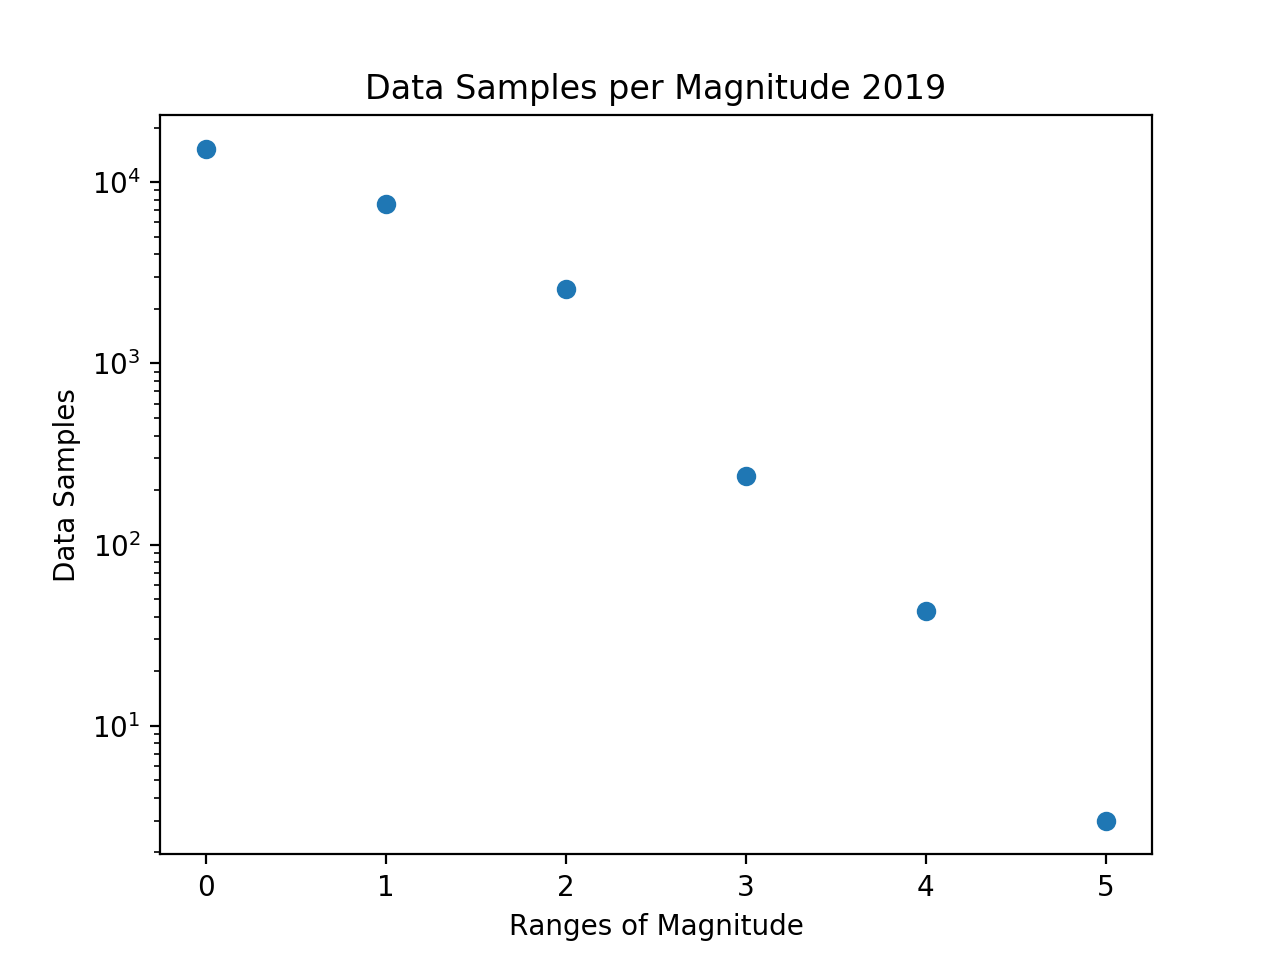

In [48]:
y_pos = np.arange(6)
performance = [10,8,6,4,2,1]

plt.scatter([0,1,2,3,4,5],mg[:-5])
plt.yscale("log")
plt.ylabel('Data Samples')
plt.xlabel('Ranges of Magnitude')
plt.title('Data Samples per Magnitude 2019')

plt.show()

<IPython.core.display.Javascript object>


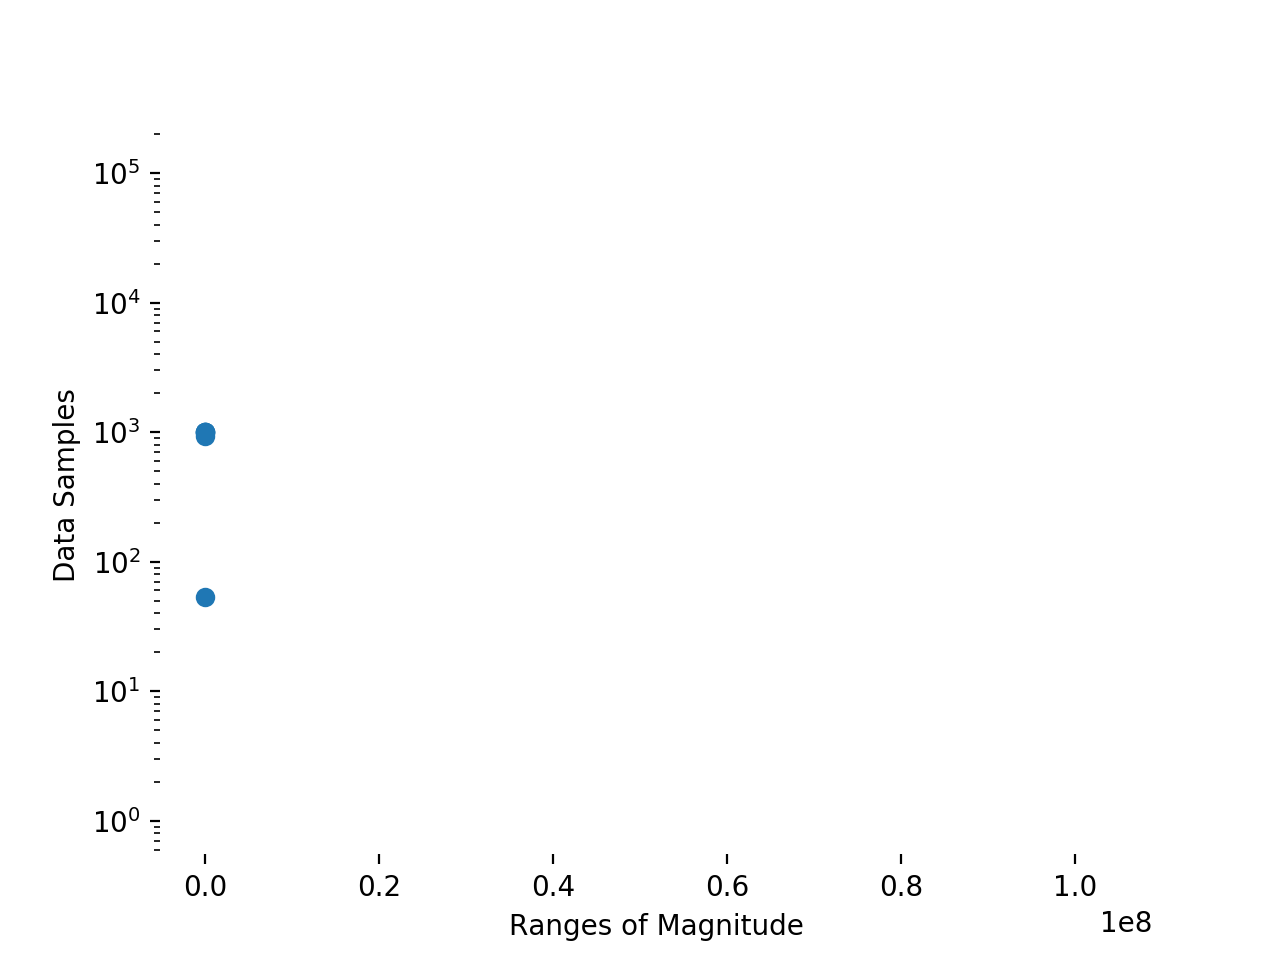

In [5]:
y_pos = np.arange(6)
performance = [10,8,6,4,2,1]

plt.scatter([0,1,2,3,4,5],mg[:-5])
plt.yscale("log")
plt.ylabel('Data Samples')
plt.xlabel('Ranges of Magnitude')
plt.title('Data Samples per Magnitude 2019')

plt.show()

# Testing MSEED data

Testing the mseed data before actually pulling it all from the database.

In [3]:
data = obspy.read("https://service.ncedc.org/fdsnws/dataselect/1/query?net=BK&sta=CMB&loc=00&cha=BHE&start=2011-11-26T09:31:00&end=2011-11-27T09:31:00")
data = np.array(data[0].data)

### Normalizing the data per second vs millisecond

In [4]:
keep_fraction = 0.01
fft_data = fftpack.fft(data)
fft_data[int(fft_data.shape[0]*keep_fraction):int(fft_data.shape[0]*(1-keep_fraction))] = 0

<IPython.core.display.Javascript object>


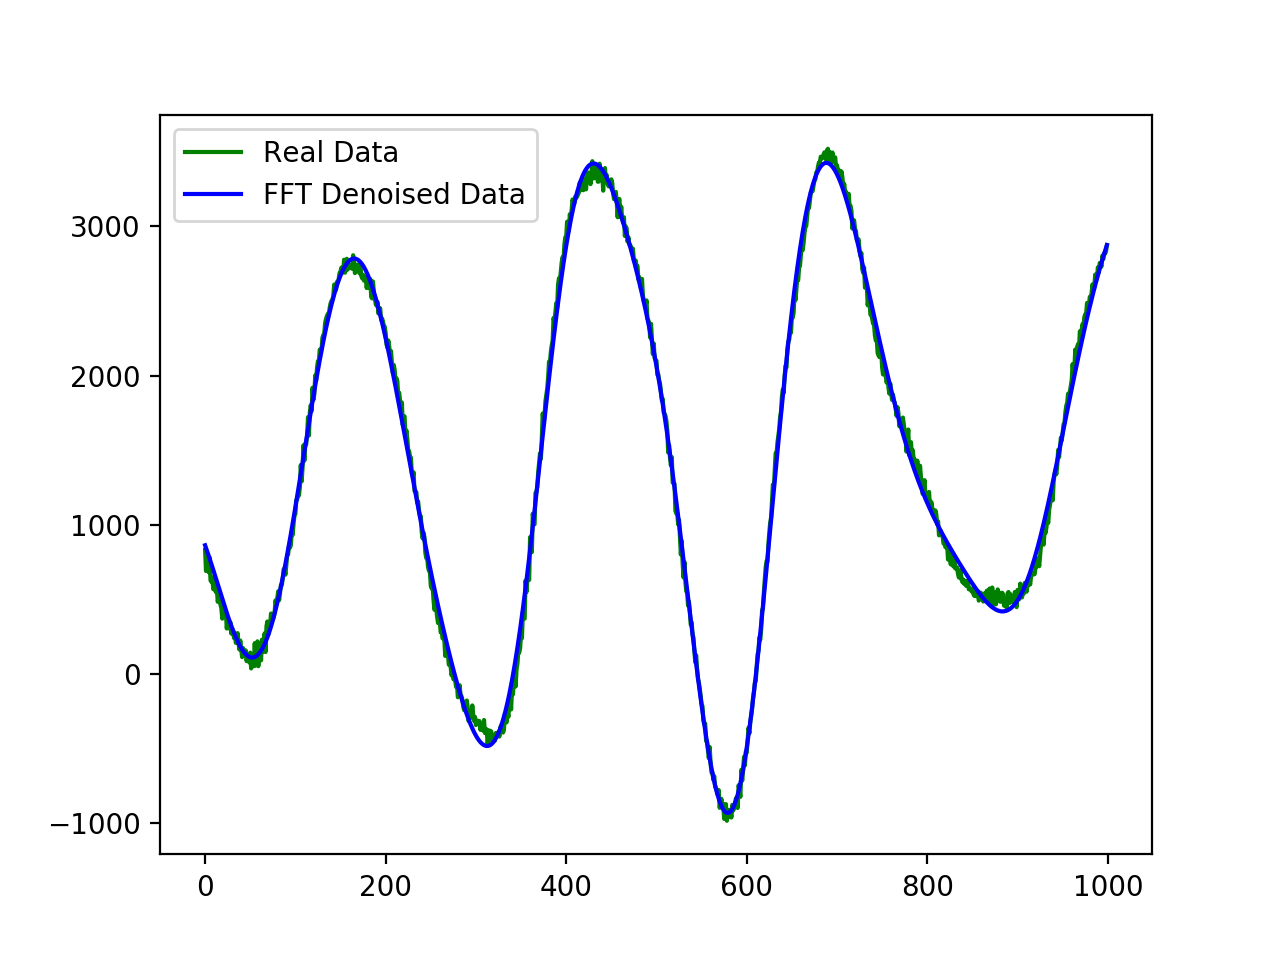

/Users/neelredkar/.conda/envs/earthquake/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [6]:
plt.plot( data[:1000], 'g', label='Real Data')
plt.plot(fftpack.ifft(fft_data)[:1000], 'b', label='FFT Denoised Data')
plt.legend()
plt.show();

# Gathering the Data

So what we are going to do in this stage is that we take the most significant earthquakes, then we take the data from a day before it, normalize it, for the X axis. Then for the Y axis we have the magnitude classification from 4-10. 

**TODO**
- Add moon phase data
- Add atmospere data

<IPython.core.display.Javascript object>


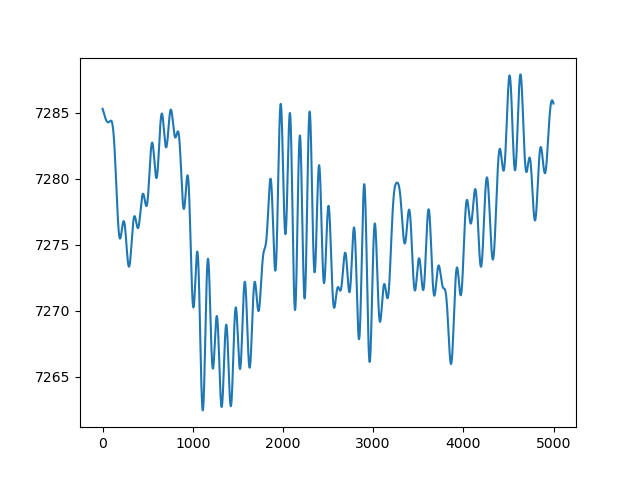

In [8]:
plt.plot(X[0].real)
plt.show()

In [ ]:
keep_fraction = 0.01
X = []
Y = []
D = []
flag = False
root = ET.fromstring(open("stations.xml").read())
for quake in tqdm(formatted_quakes):
    data = []
    print(colored("Starting new earthquake!","green"))
    time_of_quake = datetime.datetime.utcfromtimestamp(float(quake[0])).strftime("%Y-%m-%dT%H:%M:%S")
    b4_time_of_quake = datetime.datetime.utcfromtimestamp(float(quake[0])-86400).strftime("%Y-%m-%dT%H:%M:%S")
    for recorder in root[5:]:
        net =  "&net="+recorder.attrib["code"] if recorder.attrib["code"]!="" else ""
        for sta in recorder[3:]:
            station ="&sta="+sta.attrib["code"] if sta.attrib["code"]!="" else ""
            for cha in sta[5:]:
                channel = "&cha="+cha.attrib["code"] if cha.attrib["code"]!="" else ""
                loc = "&loc="+cha.attrib["locationCode"] if cha.attrib["locationCode"]!="" else ""
                url = "http://service.ncedc.org/fdsnws/dataselect/1/query?net="+net+"&sta="+station+"&loc="+loc+"&cha="+channel+"&start="+b4_time_of_quake+"&end="+time_of_quake
                if loc != "" or time.mktime(datetime.datetime.strptime(cha.attrib["startDate"], "%Y-%m-%dT%H:%M:%S").timetuple()) > float(quake[0]) or time.mktime(datetime.datetime.strptime(cha.attrib["endDate"], "%Y-%m-%dT%H:%M:%S").timetuple()) < float(quake[0]):
                    break
                print(net,station,channel)
                url = "http://service.ncedc.org/fdsnws/dataselect/1/query?"+net+station+loc+channel+"&start="+b4_time_of_quake+"&end="+time_of_quake
                print(url)
                try:
                    data = obspy.read(url,format='MSEED')
                    print(colored("Data collection from station worked","green"))
                    flag = True
                    break
                except:
                    print(colored("Did not work... Trying again","red"))
                    pass
            if flag:
                break
        if flag:
            break
    
    if len(data) > 0:
        data = np.array(data[0].data)
        data = fftpack.fft(data)
        data[int(data.shape[0]*keep_fraction):int(data.shape[0]*(1-keep_fraction))] = 0
        data = fftpack.ifft(data).real
        if len(data) >= 2000:
            data = data[len(data)%2000:]
            data = np.mean(np.split(data,len(data)/2000),axis=0)
            X.append(data)
            Y.append(quake[3])
            D.append(float(quake[0])-86400)
            np.save("X.npy",np.array(X))
            np.save("Y.npy",np.array(Y))
            np.save("D.npy",np.array(D))
        flag = False
    else:
        print(colored("NONE HAD DATA, Moving on","red"))

Starting new earthquake!
&net=BG &sta=AL1 &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=AL1&cha=DPE&start=2003-12-22T04:26:21&end=2003-12-23T04:26:21
Did not work... Trying again
&net=BG &sta=BUC &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=BUC&cha=DPE&start=2003-12-22T04:26:21&end=2003-12-23T04:26:21
Did not work... Trying again
&net=BG &sta=CLV &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=CLV&cha=DPE&start=2003-12-22T04:26:21&end=2003-12-23T04:26:21
Did not work... Trying again
&net=BG &sta=DES &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=DES&cha=DPE&start=2003-12-22T04:26:21&end=2003-12-23T04:26:21
Did not work... Trying again
&net=BG &sta=DRK &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=DRK&cha=DPE&start=2003-12-22T04:26:21&end=2003-12-23T04:26:21
Did not work... Trying again
&net=BG &sta=DVB &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/quer

http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=MNS&cha=DPE&start=2003-12-24T17:45:55&end=2003-12-25T17:45:55
Did not work... Trying again
&net=BG &sta=PFR &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=PFR&cha=DPE&start=2003-12-24T17:45:55&end=2003-12-25T17:45:55
Did not work... Trying again
&net=BG &sta=PSR &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=PSR&cha=DPE&start=2003-12-24T17:45:55&end=2003-12-25T17:45:55
Did not work... Trying again
&net=BG &sta=PSR &cha=DPN
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=PSR&cha=DPN&start=2003-12-24T17:45:55&end=2003-12-25T17:45:55
Did not work... Trying again
&net=BG &sta=PSR &cha=DPZ
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=PSR&cha=DPZ&start=2003-12-24T17:45:55&end=2003-12-25T17:45:55
Did not work... Trying again
&net=BG &sta=SB4 &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=SB4&cha=DPE&start=2003-12-24T17:45:55

http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=PSR&cha=DPZ&start=2003-12-24T08:20:01&end=2003-12-25T08:20:01
Did not work... Trying again
&net=BG &sta=SB4 &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=SB4&cha=DPE&start=2003-12-24T08:20:01&end=2003-12-25T08:20:01
Did not work... Trying again
&net=BG &sta=SQK &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=SQK&cha=DPE&start=2003-12-24T08:20:01&end=2003-12-25T08:20:01
Did not work... Trying again
&net=BG &sta=SSR &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=SSR&cha=DPE&start=2003-12-24T08:20:01&end=2003-12-25T08:20:01
Did not work... Trying again
&net=BG &sta=TCH &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=TCH&cha=DPE&start=2003-12-24T08:20:01&end=2003-12-25T08:20:01
Did not work... Trying again
&net=BG &sta=U14 &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=U14&cha=DPE&start=2003-12-24T08:20:01

http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=AL2&cha=DPE&start=2018-01-16T04:02:43&end=2018-01-17T04:02:43
Data collection from station worked
Starting new earthquake!
&net=BG &sta=AL1 &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=AL1&cha=DPE&start=2003-10-22T22:34:40&end=2003-10-23T22:34:40
Did not work... Trying again
&net=BG &sta=BUC &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=BUC&cha=DPE&start=2003-10-22T22:34:40&end=2003-10-23T22:34:40
Data collection from station worked
Starting new earthquake!
&net=BG &sta=AL2 &cha=DPE
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BG&sta=AL2&cha=DPE&start=2018-01-17T12:04:37&end=2018-01-18T12:04:37
Data collection from station worked
Starting new earthquake!
&net=BK &sta=BRIB &cha=ACD
http://service.ncedc.org/fdsnws/dataselect/1/query?&net=BK&sta=BRIB&cha=ACD&start=2001-08-21T10:01:18&end=2001-08-22T10:01:18
Data collection from station worked
Starting new earthqua

In [4]:
Y = np.load("Y.npy", allow_pickle=True)
print(type(Y[0]))
mg = np.zeros(11, dtype=int)
for i in Y:
    mg[int(float(i))] += 1
for idx,i in enumerate(mg):
    print("Magnitude "+str(idx)+" has "+str(i)+" samples")
print("Total: "+str(len(Y)))

<class 'numpy.bytes_'>
Magnitude 0 has 997 samples
Magnitude 1 has 996 samples
Magnitude 2 has 995 samples
Magnitude 3 has 759 samples
Magnitude 4 has 890 samples
Magnitude 5 has 51 samples
Magnitude 6 has 6 samples
Magnitude 7 has 0 samples
Magnitude 8 has 0 samples
Magnitude 9 has 0 samples
Magnitude 10 has 0 samples
Total: 4694


# Training the Model

In [2]:
X = np.load("X.npy", allow_pickle=True)
Y = np.load("Y.npy", allow_pickle=True)
X = tf.keras.utils.normalize(
    X,
    axis=-1
)

x_test = X[:int(len(X)*0.1)]
x_train = X[int(len(X)*0.1):]
y_test = Y[:int(len(X)*0.1)].astype(np.float)
y_train = Y[int(len(X)*0.1):].astype(np.float)

In [8]:
X.shape

(4694, 2000)

In [5]:
model = Sequential()
model.add(Dense(500, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=2,epochs=500)
model.save("earthquake_2.h5")


Train on 4225 samples, validate on 469 samples
Epoch 1/500
4225/4225 - 1s - loss: 2.0933 - accuracy: 0.0064 - val_loss: 1.8583 - val_accuracy: 0.0021
Epoch 2/500
4225/4225 - 1s - loss: 1.8313 - accuracy: 0.0064 - val_loss: 1.8693 - val_accuracy: 0.0021
Epoch 3/500
4225/4225 - 1s - loss: 1.8691 - accuracy: 0.0064 - val_loss: 1.7902 - val_accuracy: 0.0021
Epoch 4/500
4225/4225 - 1s - loss: 1.7712 - accuracy: 0.0064 - val_loss: 1.7759 - val_accuracy: 0.0021
Epoch 5/500
4225/4225 - 1s - loss: 1.8024 - accuracy: 0.0064 - val_loss: 1.8158 - val_accuracy: 0.0021
Epoch 6/500
4225/4225 - 1s - loss: 1.7662 - accuracy: 0.0064 - val_loss: 1.7078 - val_accuracy: 0.0021
Epoch 7/500
4225/4225 - 1s - loss: 1.7683 - accuracy: 0.0064 - val_loss: 1.7248 - val_accuracy: 0.0021
Epoch 8/500
4225/4225 - 1s - loss: 1.7558 - accuracy: 0.0064 - val_loss: 1.7115 - val_accuracy: 0.0021
Epoch 9/500
4225/4225 - 1s - loss: 1.7559 - accuracy: 0.0064 - val_loss: 1.8478 - val_accuracy: 0.0021
Epoch 10/500
4225/4225 - 1

Epoch 80/500
4225/4225 - 1s - loss: 1.7252 - accuracy: 0.0064 - val_loss: 1.6955 - val_accuracy: 0.0021
Epoch 81/500
4225/4225 - 1s - loss: 1.7173 - accuracy: 0.0064 - val_loss: 1.7163 - val_accuracy: 0.0021
Epoch 82/500
4225/4225 - 1s - loss: 1.7274 - accuracy: 0.0064 - val_loss: 1.6964 - val_accuracy: 0.0021
Epoch 83/500
4225/4225 - 1s - loss: 1.7241 - accuracy: 0.0064 - val_loss: 1.7144 - val_accuracy: 0.0021
Epoch 84/500
4225/4225 - 1s - loss: 1.7227 - accuracy: 0.0064 - val_loss: 1.7114 - val_accuracy: 0.0021
Epoch 85/500
4225/4225 - 1s - loss: 1.7203 - accuracy: 0.0064 - val_loss: 1.7094 - val_accuracy: 0.0021
Epoch 86/500
4225/4225 - 1s - loss: 1.7274 - accuracy: 0.0064 - val_loss: 1.6943 - val_accuracy: 0.0021
Epoch 87/500
4225/4225 - 1s - loss: 1.7235 - accuracy: 0.0064 - val_loss: 1.7024 - val_accuracy: 0.0021
Epoch 88/500
4225/4225 - 1s - loss: 1.7216 - accuracy: 0.0064 - val_loss: 1.7041 - val_accuracy: 0.0021
Epoch 89/500
4225/4225 - 1s - loss: 1.7248 - accuracy: 0.0064 - 

Epoch 159/500
4225/4225 - 1s - loss: 1.7083 - accuracy: 0.0064 - val_loss: 1.6838 - val_accuracy: 0.0021
Epoch 160/500
4225/4225 - 1s - loss: 1.7053 - accuracy: 0.0064 - val_loss: 1.7160 - val_accuracy: 0.0021
Epoch 161/500
4225/4225 - 1s - loss: 1.7033 - accuracy: 0.0064 - val_loss: 1.6621 - val_accuracy: 0.0021
Epoch 162/500
4225/4225 - 1s - loss: 1.6943 - accuracy: 0.0064 - val_loss: 1.6689 - val_accuracy: 0.0021
Epoch 163/500
4225/4225 - 1s - loss: 1.6985 - accuracy: 0.0064 - val_loss: 1.6606 - val_accuracy: 0.0021
Epoch 164/500
4225/4225 - 1s - loss: 1.6993 - accuracy: 0.0064 - val_loss: 1.6786 - val_accuracy: 0.0021
Epoch 165/500
4225/4225 - 1s - loss: 1.6910 - accuracy: 0.0064 - val_loss: 1.6727 - val_accuracy: 0.0021
Epoch 166/500
4225/4225 - 1s - loss: 1.6967 - accuracy: 0.0064 - val_loss: 1.6686 - val_accuracy: 0.0021
Epoch 167/500
4225/4225 - 1s - loss: 1.7067 - accuracy: 0.0064 - val_loss: 1.6592 - val_accuracy: 0.0021
Epoch 168/500
4225/4225 - 1s - loss: 1.6924 - accuracy:

Epoch 315/500
4225/4225 - 1s - loss: 1.6736 - accuracy: 0.0064 - val_loss: 1.6956 - val_accuracy: 0.0021
Epoch 316/500
4225/4225 - 1s - loss: 1.6715 - accuracy: 0.0064 - val_loss: 1.6564 - val_accuracy: 0.0021
Epoch 317/500
4225/4225 - 1s - loss: 1.6701 - accuracy: 0.0064 - val_loss: 1.6755 - val_accuracy: 0.0021
Epoch 318/500
4225/4225 - 1s - loss: 1.6931 - accuracy: 0.0064 - val_loss: 1.6581 - val_accuracy: 0.0021
Epoch 319/500
4225/4225 - 1s - loss: 1.6798 - accuracy: 0.0064 - val_loss: 1.6509 - val_accuracy: 0.0021
Epoch 320/500
4225/4225 - 1s - loss: 1.6776 - accuracy: 0.0064 - val_loss: 1.6479 - val_accuracy: 0.0021
Epoch 321/500
4225/4225 - 1s - loss: 1.6674 - accuracy: 0.0064 - val_loss: 1.6563 - val_accuracy: 0.0021
Epoch 322/500
4225/4225 - 1s - loss: 1.6781 - accuracy: 0.0064 - val_loss: 1.6445 - val_accuracy: 0.0021
Epoch 323/500
4225/4225 - 1s - loss: 1.6744 - accuracy: 0.0064 - val_loss: 1.6569 - val_accuracy: 0.0021
Epoch 324/500
4225/4225 - 1s - loss: 1.6792 - accuracy:

Epoch 471/500
4225/4225 - 1s - loss: 1.6590 - accuracy: 0.0064 - val_loss: 1.6471 - val_accuracy: 0.0021
Epoch 472/500
4225/4225 - 1s - loss: 1.6592 - accuracy: 0.0064 - val_loss: 1.6480 - val_accuracy: 0.0021
Epoch 473/500
4225/4225 - 1s - loss: 1.6597 - accuracy: 0.0064 - val_loss: 1.7241 - val_accuracy: 0.0021
Epoch 474/500
4225/4225 - 1s - loss: 1.6958 - accuracy: 0.0064 - val_loss: 1.6592 - val_accuracy: 0.0021
Epoch 475/500
4225/4225 - 1s - loss: 1.6623 - accuracy: 0.0064 - val_loss: 1.6499 - val_accuracy: 0.0021
Epoch 476/500
4225/4225 - 1s - loss: 1.6646 - accuracy: 0.0064 - val_loss: 1.6547 - val_accuracy: 0.0021
Epoch 477/500
4225/4225 - 1s - loss: 1.6636 - accuracy: 0.0064 - val_loss: 1.6434 - val_accuracy: 0.0021
Epoch 478/500
4225/4225 - 1s - loss: 1.6592 - accuracy: 0.0064 - val_loss: 1.6323 - val_accuracy: 0.0021
Epoch 479/500
4225/4225 - 1s - loss: 1.6677 - accuracy: 0.0064 - val_loss: 1.6322 - val_accuracy: 0.0021
Epoch 480/500
4225/4225 - 1s - loss: 1.6629 - accuracy:

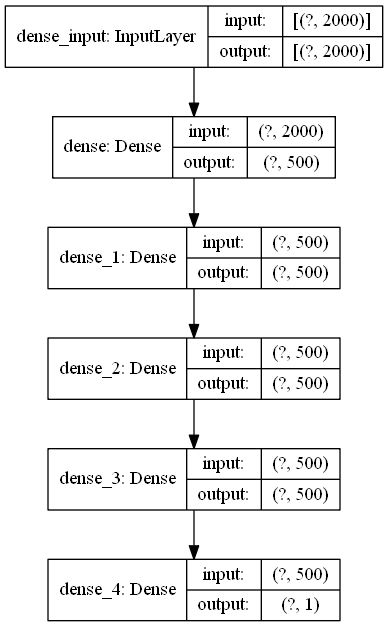

In [4]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<IPython.core.display.Javascript object>


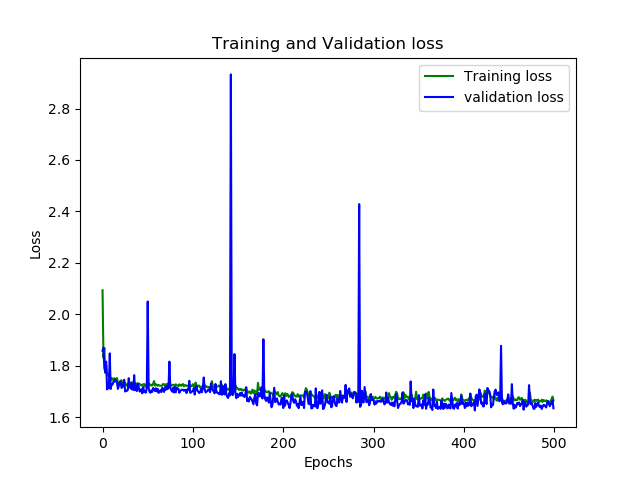

In [32]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,500)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()